***Autoencoder*** has two main components: An Encoder and a Decoder

Encoder: Compresses the Image Data (Flattening).

Decoder: Reconstructs image using compressed data.

![a](cnn_img/b1.png)

There are many applications of autoencoders such as image reconstruction or converting to greyscale. In the next section I will be building a linear autoencoder.

# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

<img src='cnn_img/autoencoder_1.png' />

### Compressed Representation

A compressed representation can be great for saving and sharing any kind of data in a way that is more efficient than storing raw data. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or oher kinds of reconstruction and transformation!

<img src='cnn_img/denoising.png' width=60%/>

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
# Imports

import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Converts data to torch.FloatTensor
transform = transforms.ToTensor()

#Load training data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create training and test dataloaders
num_workers = 0
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# obtain one batch of training images
data_iter = iter(train_loader)
images, label = data_iter.next()
images = images.numpy()

### Visualize the Data

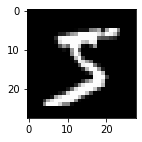

In [3]:
# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (2,2)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---
## Linear Autoencoder

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building a simple autoencoder. The encoder and decoder should be made of **one linear layer**. The units that connect the encoder and decoder will be the _compressed representation_.

Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values that match this input value range.

<img src='cnn_img/simple_autoencoder.png' width=50% />


#### Build the graph for the autoencoder in the cell below. 
> The input images will be flattened into 784 length vectors. The targets are the same as the inputs. 
> The encoder and decoder will be made of two linear layers, each.
> The depth dimensions should change as follows: 784 inputs > **encoding_dim** > 784 outputs.
> All layers will have ReLu activations applied except for the final output layer, which has a sigmoid activation.

**The compressed representation should be a vector with dimension `encoding_dim=32`.**

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(28 *28 , encoding_dim) #(input size -> encoding_dim), Compression
        
        # Decoder
        self.fc2 = nn.Linear(encoding_dim, 28*28) #(encoding_dim -> input size), Decompression
        
    def forward(self, x):
        
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [5]:
# initialize the NN
encoding_dim = 32
model = Autoencoder(encoding_dim)
print(model)

Autoencoder(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing _quantities_ rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. We flatten our images, pass them into the autoencoder, and record the training loss as we go.

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

n_epoch = 20

for epoch in range(1, n_epoch+1):
    
    train_loss = 0.0 #monitor training loss
    
    #Train model
    for data in train_loader: #Not concerned about labels
        images, labels = data #Seperate the pair
        images = images.view(images.size(0), -1) # flatten images into 1-d vector
        optimizer.zero_grad() # Reset Gradient Vals
        output = model(images) # Foward Pass
        loss = criterion(output, images) #MSE Error
        loss.backward() # Gradient Descent
        optimizer.step() # Backpropagation
        train_loss += loss.item()*images.size(0) # update running training loss
        
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))        

Epoch: 1 	Training Loss: 0.628202
Epoch: 2 	Training Loss: 0.295201
Epoch: 3 	Training Loss: 0.250456
Epoch: 4 	Training Loss: 0.242772
Epoch: 5 	Training Loss: 0.239313
Epoch: 6 	Training Loss: 0.237183
Epoch: 7 	Training Loss: 0.235740
Epoch: 8 	Training Loss: 0.234426
Epoch: 9 	Training Loss: 0.233414
Epoch: 10 	Training Loss: 0.232508
Epoch: 11 	Training Loss: 0.231778
Epoch: 12 	Training Loss: 0.231136
Epoch: 13 	Training Loss: 0.230565
Epoch: 14 	Training Loss: 0.230031
Epoch: 15 	Training Loss: 0.229524
Epoch: 16 	Training Loss: 0.228996
Epoch: 17 	Training Loss: 0.228506
Epoch: 18 	Training Loss: 0.228111
Epoch: 19 	Training Loss: 0.227750
Epoch: 20 	Training Loss: 0.227414


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

torch.Size([20, 784])
First Row is original, the second row is the decoded images


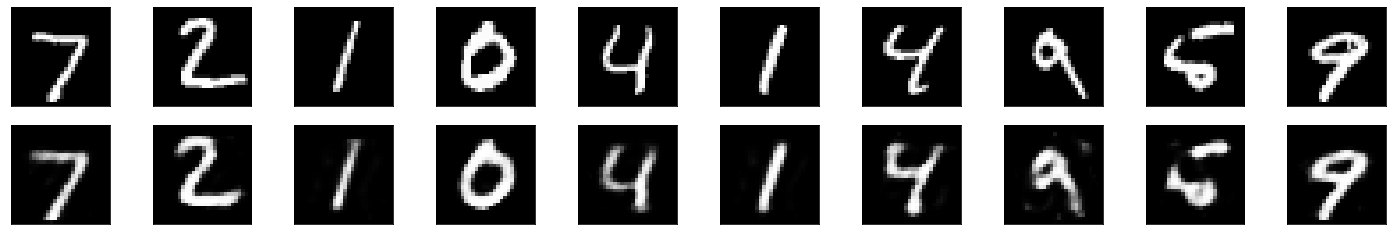

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

images_flatten = images.view(images.size(0), -1)
print(images_flatten.size())
output = model(images_flatten)

# prep images for display
images = images.numpy()
output = output.view(batch_size, 1, 28,28) # output is resized into a batch of images
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
print('First Row is original, the second row is the decoded images')

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

Convolutions layers provide a method of preserve spatial info.

The convolutional encoder is made up of a serious of convolution layers ment to retain patterns about the images in depth up until the compressed representation. PyTorch using the term "Upsampling" to define these operations.

![b](cnn_img/b2.png)


---


The de-pooling or "decoding" layer is made up of layers that perform algorithms such as Nearest Neighbours or Linear Interpolation to resize the image back to its original state.

![b](cnn_img/b3.png)

Instead we can use a transpose convolutional layer, which is a convolution layer that upscale the feature maps provided. Here is how it works: 

Instead of reducing our layer size by having kernals slide over our inputs we can take a larger kernal (3x3) to expand the feauture maps. As we can see, for each pixel a 3x3 takes form to expand the resultant feature map.

![b](cnn_img/b4.png)

One problem could occur when overlapping maps causes the intensity values to sum up. A quick resolution is to use a 2x2 filter with a stride of 2 to prevent overlap.

![b](cnn_img/b6.png)

